In [1]:
import numpy as np
import pandas as pd

#data visualization
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Dataset Description
## A real-world noisy EMI default prediction dataset of an Indian bank for Tier 3 towns and suburbs which also Canara Bank majorly focuses on the RAM sector.
## With nearly 88% belonging to the majority class and some irrelevant and highly null values columns, it gives an industry experience to students. 
## The details of each column are given in the first sheet to have a brief understanding.

In [2]:
path = '/kaggle/input/canara-hackathon/Canara Hackathon/'
training_data1 = pd.read_csv(path + 'Training data file.csv') 
testing_data  = pd.read_csv(path + 'Validation Data file.csv')

In [3]:
missing_data = training_data1.isnull().sum()
missing_data = missing_data[missing_data > 0].sort_values(ascending=False)
missing_percentage = (missing_data / len(training_data1)) * 100
missing_percentage

CoAp_Income                 94.931879
Max_Ratio_OC_Pending_POS    89.407160
Total_Field_Trails          67.335360
Total_Resolved              61.911560
Perc_Paymode_Cheq_Fail      28.893702
Max_Perc_Def_Chg_Pending    25.941196
N_PosBkt_L3m                 6.569604
Max_Loan_Balance_Others      0.419677
Max_DPD_L3m                  0.299066
dtype: float64

# First Observations
1. We have some missing values represented by NaN.
2. The Ever_Default_L12M column has categorical string values ('Yes' and 'No'). We should convert this to a binary format (1 for 'Yes' and 0 for 'No').
3. The N_Family_Member column has negative values, which is not valid. We need to address these.
4. There might be other inconsistencies or outliers that we need to check.
5. Dropping of columns with null values >65%
6. 'Customer_No', 'Branch_Code', 'Birth_Year' not needed.(Age already given)

In [4]:
# Drop columns with a high percentage of missing values
columns_to_drop = ['CoAp_Income', 'Max_Ratio_OC_Pending_POS', 'Total_Field_Trails', 'Customer_No', 'Branch_Code', 'Birth_Year', 'Total_Resolved']
training_data = training_data1.drop(columns=columns_to_drop)
training_data.head()

,N_Default_L3m,Max_Utilization,Max_Perc_Def_Chg_Pending,N_Family_Member,N_PosBkt_L3m,Ever_Default_L12M,Perc_Paymode_Online,Perc_Repay_Fail,Max_DPD_L3m,Perc_Paymode_Cheq_Fail,Age,N_Enq_L9m,Max_Loan_Balance_Others,N_WorkEx_Yr,Target_Flag
0,3,38,100.0,5,0.0,Yes,0.285714,0.428571,19.0,0.750,46,0,5527.0,15,0
1,1,68,100.0,1,0.0,Yes,0.000000,0.200000,2.0,0.500,33,0,12104.0,2,0
2,1,39,50.0,-3,0.0,Yes,0.200000,0.200000,25.0,1.000,28,1,153179.0,8,0
3,0,76,NaN,0,0.0,No,0.000000,0.000000,0.0,NaN,26,2,181589.0,6,0
4,3,23,33.0,11,0.0,Yes,0.250000,0.250000,19.0,0.375,28,1,10661.0,8,0


# Data Preprocessing:

1. Percentage of Times Repayment Mode Was 'Cheque' and Was Not Cleared and Max Percentage of Default Charges Pending:

Reasoning: A cheque not being cleared often signifies a lack of funds or a mismatch of details, which can also correlate with the individual not paying their default charges.

2. Percentage of Times Repayment Mode Was Online and Percentage of Times Repayment Failure:

Financial Reasoning: Online repayments are generally more reliable than traditional methods like cheques. 

3. Convert Categorical to Numerical: 
Convert the Ever_Default_L12M column to binary format.

4. Handle Inconsistencies: 
Address negative values in the N_Family_Member column.

In [5]:
# 1. Handling Negative Family Members based on Age and Indian trends
training_data.loc[(training_data['N_Family_Member'] < 0) & (training_data['Age'] < 25), 'N_Family_Member'] = 0
training_data.loc[(training_data['N_Family_Member'] < 0) & (training_data['Age'] >= 25) & (training_data['Age'] < 30), 'N_Family_Member'] = 4
training_data.loc[(training_data['N_Family_Member'] < 0) & (training_data['Age'] >= 30) & (training_data['Age'] < 65), 'N_Family_Member'] = 3

# 2. Convert Categorical to Numerical
training_data['Ever_Default_L12M'] = training_data['Ever_Default_L12M'].map({"Yes": 1, "No": 0})

# 3. Impute based on inverse relationship between "Perc_Paymode_Online" and "Perc_Repay_Fail" as it is highly logical as there are less occurences of payment failures online
indices_3 = training_data[training_data['Perc_Paymode_Online'].isna()].index
indices_4 = training_data[training_data['Perc_Repay_Fail'].isna()].index
training_data.loc[indices_3, 'Perc_Paymode_Online'] = 1 - training_data.loc[indices_3, 'Perc_Repay_Fail']
training_data.loc[indices_4, 'Perc_Repay_Fail'] = 1 - training_data.loc[indices_4, 'Perc_Paymode_Online']

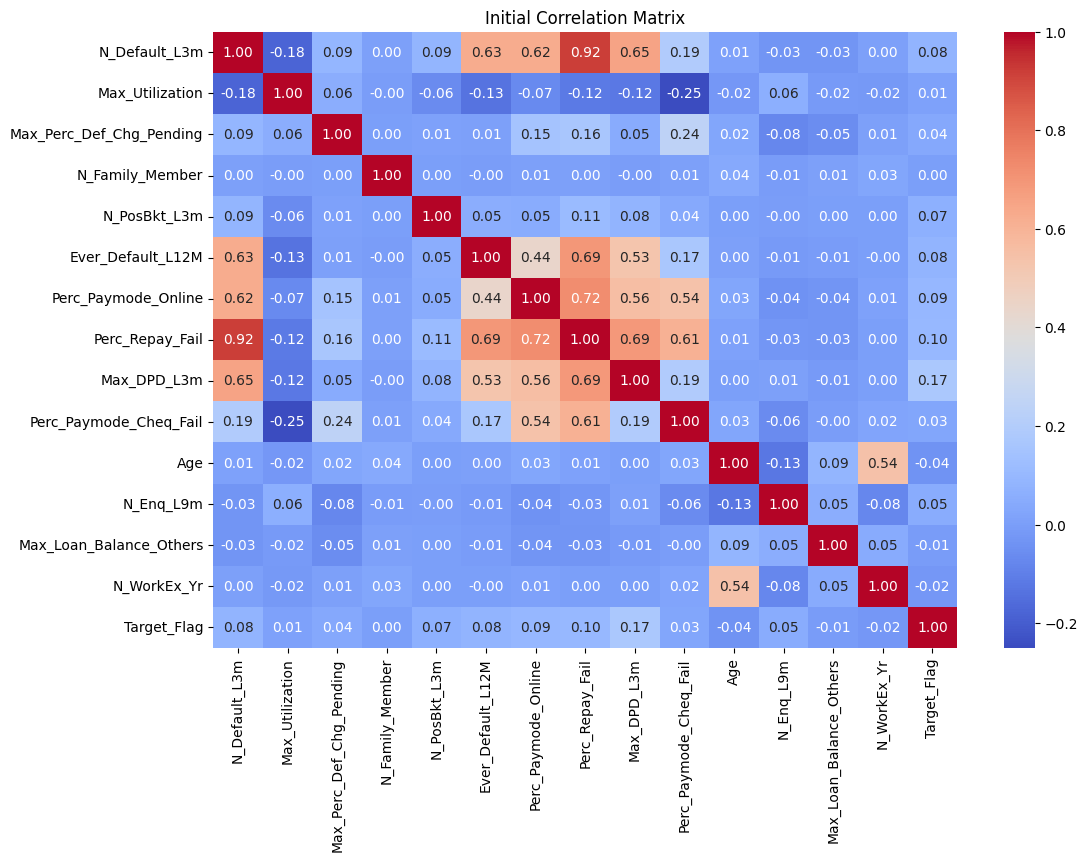

{'N_Default_L3m': ['Ever_Default_L12M', 'Perc_Paymode_Online', 'Perc_Repay_Fail', 'Max_DPD_L3m'], 'Ever_Default_L12M': ['N_Default_L3m', 'Perc_Repay_Fail'], 'Perc_Paymode_Online': ['N_Default_L3m', 'Perc_Repay_Fail'], 'Perc_Repay_Fail': ['N_Default_L3m', 'Ever_Default_L12M', 'Perc_Paymode_Online', 'Max_DPD_L3m', 'Perc_Paymode_Cheq_Fail'], 'Max_DPD_L3m': ['N_Default_L3m', 'Perc_Repay_Fail'], 'Perc_Paymode_Cheq_Fail': ['Perc_Repay_Fail']}


In [6]:
correlation_matrix = training_data.corr()

# Filter out columns that have significant correlation for potential imputations
correlated_pairs = {}
for col in correlation_matrix.columns:
    top_corr_cols = correlation_matrix[col].index[correlation_matrix[col].abs() > 0.6].tolist()
    top_corr_cols.remove(col)  # remove self correlation
    if top_corr_cols:
        correlated_pairs[col] = top_corr_cols

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Initial Correlation Matrix")
plt.show()
print(correlated_pairs)

# KNN imputation 
1. It takes into account the "similarity" between data points and can provide more accurate imputations in comparison to mean/median imputation.
2. Iterative imputer uses regression to predict the missing value, knnimputer looks for nearest neighbour and has their average

## Financial Reasoning: 
A customer's behavior in one financial aspect (like the number of positive buckets in the last 3 months) can be influenced by or related to other financial behaviors (like the maximum days past due). Thus, using information from related columns to impute missing values can give a more accurate representation of the missing values.

In [7]:
missing_data = training_data.isnull().sum()
missing_data = missing_data[missing_data > 0].sort_values(ascending=False)

missing_data

Perc_Paymode_Cheq_Fail      23477
Max_Perc_Def_Chg_Pending    21078
N_PosBkt_L3m                 5338
Max_Loan_Balance_Others       341
Max_DPD_L3m                   243
dtype: int64

In [8]:
# List of columns to impute
cols_to_impute = ['N_Default_L3m','Max_Perc_Def_Chg_Pending', 'Perc_Paymode_Cheq_Fail', 
                  'N_PosBkt_L3m', 'Max_DPD_L3m', 'Max_Loan_Balance_Others', 'Perc_Repay_Fail']

from sklearn.impute import KNNImputer

# Initialize KNN imputer
knn_imputer = KNNImputer(n_neighbors=7)

# Apply KNN imputation for the selected columns
training_data[cols_to_impute] = knn_imputer.fit_transform(training_data[cols_to_impute])


In [9]:
training_data['Perc_Paymode_Cheq_Fail'] = training_data['Perc_Paymode_Cheq_Fail'].apply(lambda x: x / 100 if x > 1 else x)
training_data['Max_Perc_Def_Chg_Pending'] = training_data['Max_Perc_Def_Chg_Pending'].apply(lambda x: x * 100 if x < 1 else x)
training_data['N_WorkEx_Yr'] = training_data['N_WorkEx_Yr'].apply(lambda x: abs(x))
for col in training_data.select_dtypes(include=['float64', 'int64']).columns:
    training_data[col].fillna(0, inplace=True)

In [10]:
value_counts = training_data['Target_Flag'].value_counts()

# Check if 0 is in the value_counts Series and get the count
count_of_zeros = value_counts.get(0, 0)

count_of_zeros/len(training_data['Target_Flag'])

0.8795859845174947

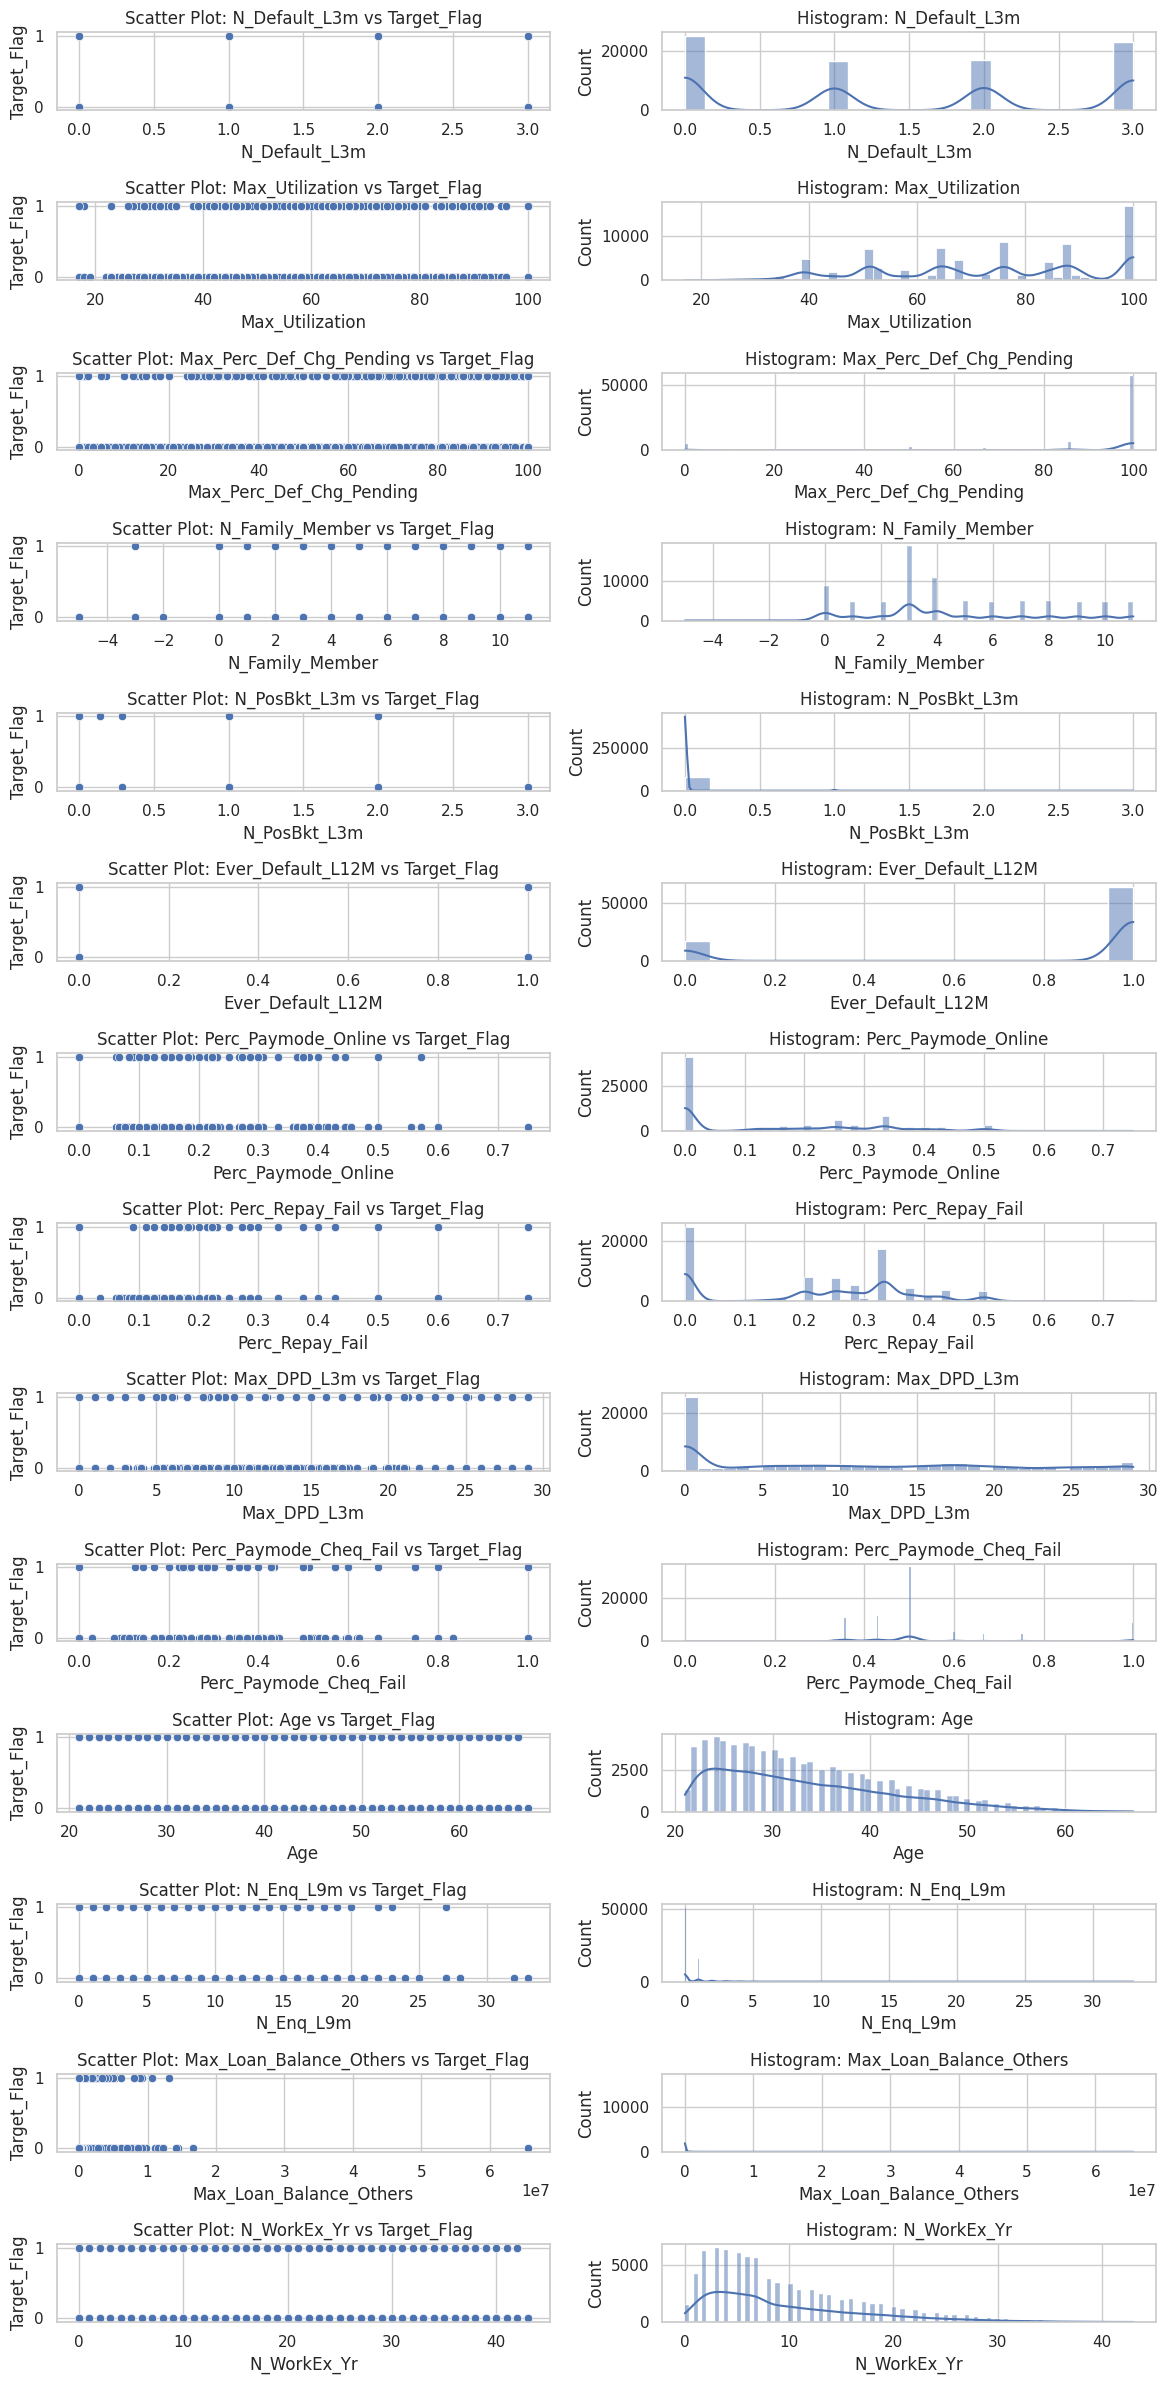

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the style for Seaborn (optional)
sns.set(style="whitegrid")

# List of attributes/features
attributes = [
    "N_Default_L3m",
    "Max_Utilization",
    "Max_Perc_Def_Chg_Pending",
    "N_Family_Member",
    "N_PosBkt_L3m",
    "Ever_Default_L12M",
    "Perc_Paymode_Online",
    "Perc_Repay_Fail",
    "Max_DPD_L3m",
    "Perc_Paymode_Cheq_Fail",
    "Age",
    "N_Enq_L9m",
    "Max_Loan_Balance_Others",
    "N_WorkEx_Yr",
]

# Set the number of subplots for visualization
num_subplots = len(attributes)

# Create subplots
fig, axes = plt.subplots(num_subplots, 2, figsize=(12, 24))

# Loop through attributes and create scatter plots and histograms
for i, attr in enumerate(attributes):
    # Scatter plot
    sns.scatterplot(x=training_data[attr], y=training_data["Target_Flag"], ax=axes[i, 0])
    axes[i, 0].set_title(f"Scatter Plot: {attr} vs Target_Flag")

    # Histogram
    sns.histplot(data=training_data, x=attr, kde=True, ax=axes[i, 1])
    axes[i, 1].set_title(f"Histogram: {attr}")

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()


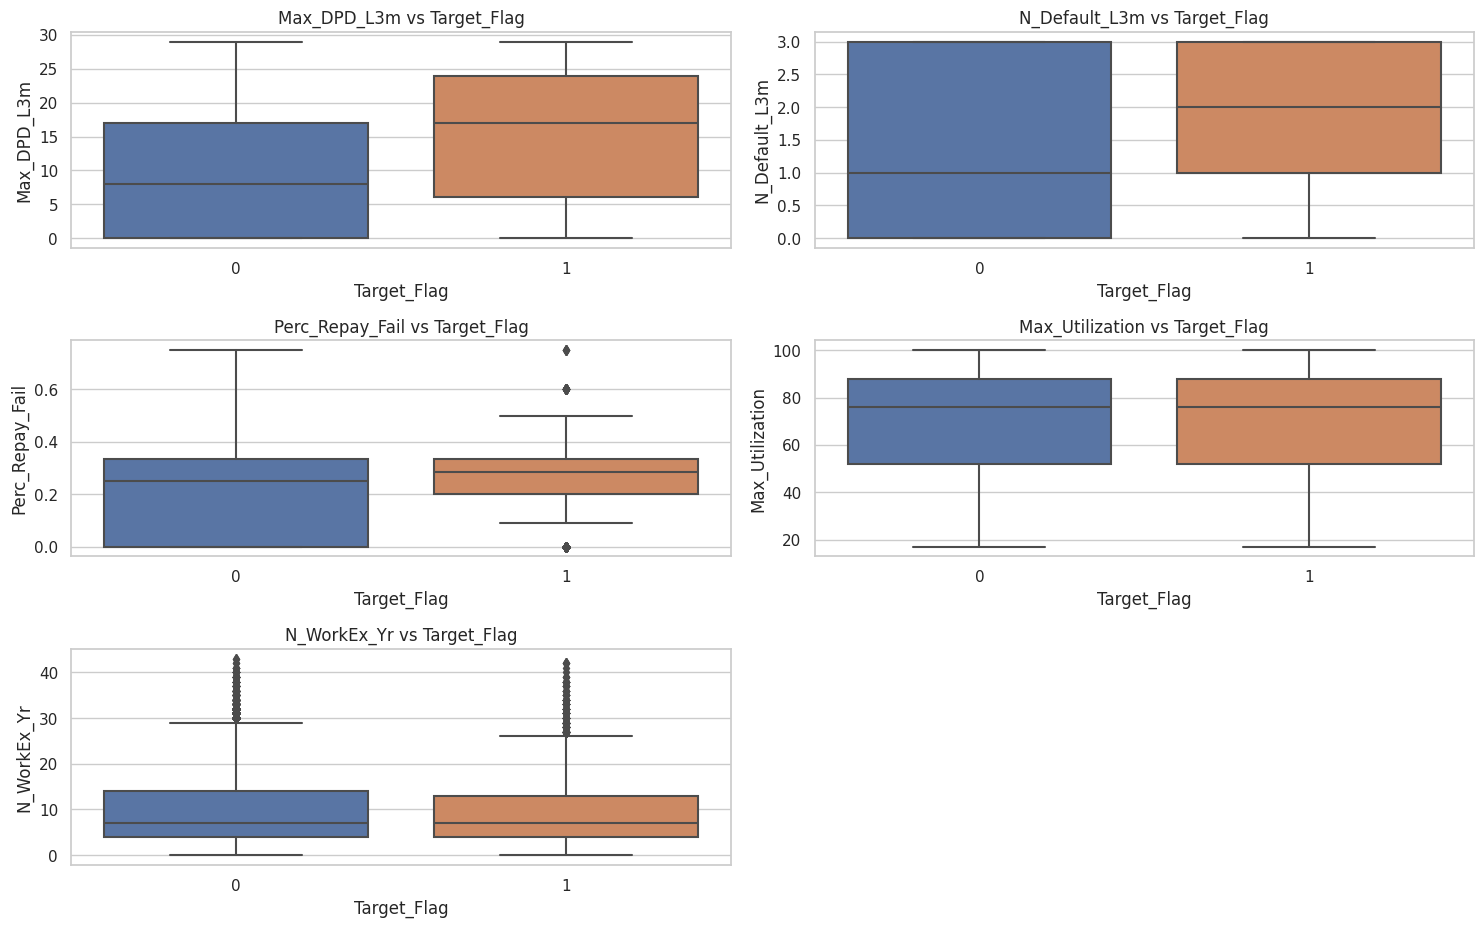

In [12]:
# Bivariate Analysis using box plots
poly_features = ['Max_DPD_L3m','N_Default_L3m', 'Perc_Repay_Fail', 'Max_Utilization', 'N_WorkEx_Yr']
plt.figure(figsize=(15, 12))

for i, feature in enumerate(poly_features, 1):
    plt.subplot(4, 2, i)
    sns.boxplot(x='Target_Flag', y=feature, data=training_data)
    plt.title(f'{feature} vs Target_Flag')
    plt.xlabel('Target_Flag')
    plt.ylabel(feature)

plt.tight_layout()
plt.show()

## Key observations for Risk factors:
1. Max_DPD_L3m vs Target_Flag: 
This aligns with our expectation that customers who have been late in their payments are more likely to default.

2. N_Default_L3m vs Target_Flag: 
Defaulting customers tend to have a higher number of defaults in the last 3 months, which is expected.

3. Perc_Repay_Fail vs Target_Flag: 
The defaulting group has a noticeably higher median percentage of repayment failures. This suggests that customers who have had more repayment failures in the past are more prone to defaulting.

4. Max_Utilization vs Target_Flag: 
We can observe that the median utilization for defaulting customers is slightly higher than for non-defaulting customers. This suggests that customers who fully utilize their credit might be at a higher risk of defaulting.

5. N_WorkEx_Yr vs Target_Flag: 
Defaulting customers tend to have slightly less work experience compared to non-defaulting customers.

## Feature Engineering
After doing **Polynomial=2** and generating some **new features**, I derived at following conclusion.
The poly_features defined above need to be scaled above so that in the skewed dataset they have a even higher correlation.

In [13]:
training_data.head()

,N_Default_L3m,Max_Utilization,Max_Perc_Def_Chg_Pending,N_Family_Member,N_PosBkt_L3m,Ever_Default_L12M,Perc_Paymode_Online,Perc_Repay_Fail,Max_DPD_L3m,Perc_Paymode_Cheq_Fail,Age,N_Enq_L9m,Max_Loan_Balance_Others,N_WorkEx_Yr,Target_Flag
0,3.0,38,100.0,5,0.0,1,0.285714,0.428571,19.0,0.750000,46,0,5527.0,15,0
1,1.0,68,100.0,1,0.0,1,0.000000,0.200000,2.0,0.500000,33,0,12104.0,2,0
2,1.0,39,50.0,4,0.0,1,0.200000,0.200000,25.0,1.000000,28,1,153179.0,8,0
3,0.0,76,100.0,0,0.0,0,0.000000,0.000000,0.0,0.357143,26,2,181589.0,6,0
4,3.0,23,33.0,11,0.0,1,0.250000,0.250000,19.0,0.375000,28,1,10661.0,8,0


In [14]:
import numpy as np

# Assuming 'feature_1' is the name of the column you want to square root

for i in range(len(poly_features)):
    feature_1 = poly_features[i]
    training_data[feature_1] = (training_data[feature_1]*training_data[feature_1])
training_data.head()

,N_Default_L3m,Max_Utilization,Max_Perc_Def_Chg_Pending,N_Family_Member,N_PosBkt_L3m,Ever_Default_L12M,Perc_Paymode_Online,Perc_Repay_Fail,Max_DPD_L3m,Perc_Paymode_Cheq_Fail,Age,N_Enq_L9m,Max_Loan_Balance_Others,N_WorkEx_Yr,Target_Flag
0,9.0,1444,100.0,5,0.0,1,0.285714,0.183673,361.0,0.750000,46,0,5527.0,225,0
1,1.0,4624,100.0,1,0.0,1,0.000000,0.040000,4.0,0.500000,33,0,12104.0,4,0
2,1.0,1521,50.0,4,0.0,1,0.200000,0.040000,625.0,1.000000,28,1,153179.0,64,0
3,0.0,5776,100.0,0,0.0,0,0.000000,0.000000,0.0,0.357143,26,2,181589.0,36,0
4,9.0,529,33.0,11,0.0,1,0.250000,0.062500,361.0,0.375000,28,1,10661.0,64,0


# Why we shouldn't delete outliers?

In [15]:
from collections import Counter

numeric_columns= (list(training_data.loc[:, 'N_Default_L3m':'N_WorkEx_Yr']))

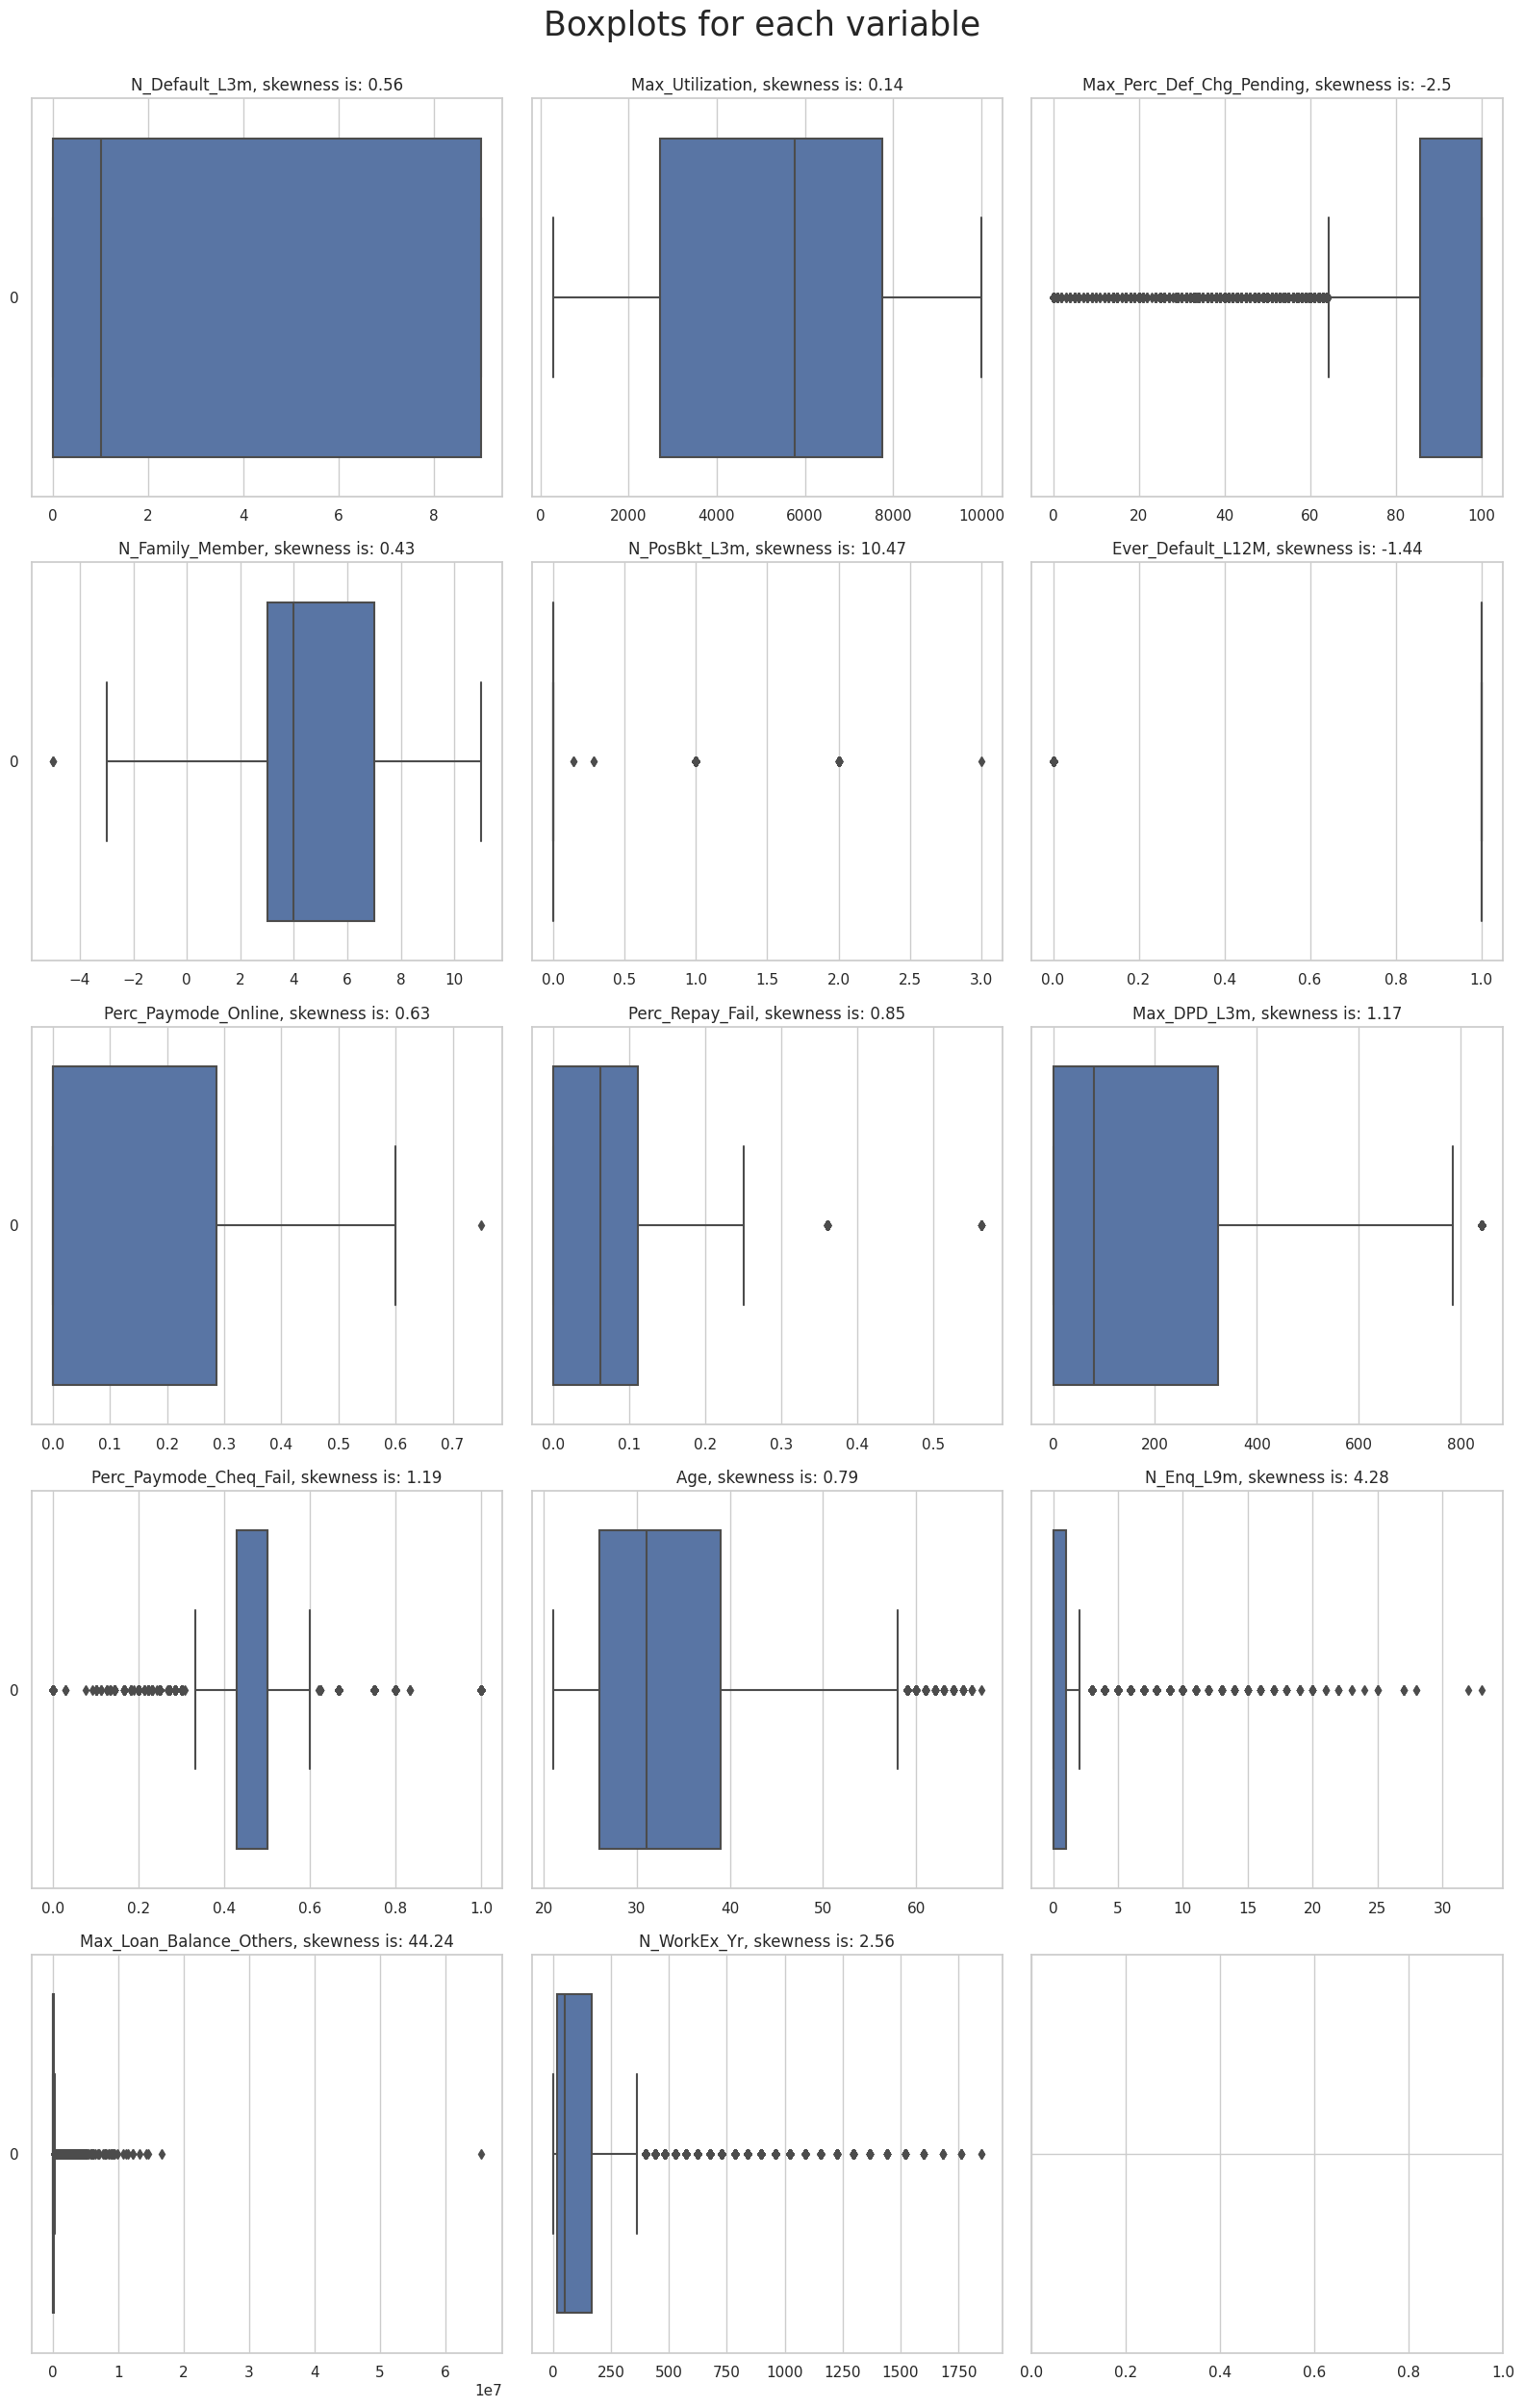

In [16]:
# checking boxplots
def boxplots_custom(dataset, columns_list, rows, cols, suptitle):
    fig, axs = plt.subplots(rows, cols, sharey=True, figsize=(16,25))
    fig.suptitle(suptitle,y=1, size=25)
    axs = axs.flatten()
    for i, data in enumerate(columns_list):
        sns.boxplot(data=dataset[data], orient='h', ax=axs[i])
        axs[i].set_title(data + ', skewness is: '+str(round(dataset[data].skew(axis = 0, skipna = True),2)))
        
boxplots_custom(dataset=training_data, columns_list=numeric_columns, rows=5, cols=3, suptitle='Boxplots for each variable')
plt.tight_layout()

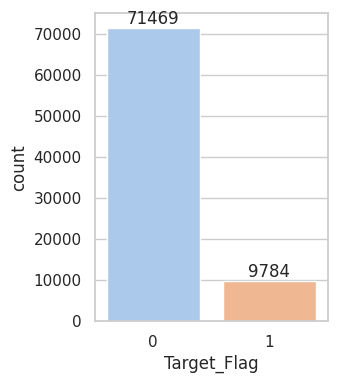

In [17]:
plt.figure(figsize=(3,4))
ax = sns.countplot(x='Target_Flag',data=training_data,palette="pastel")
for i in ax.containers:
    ax.bar_label(i,)

## IQR
Inter Quartile Range (IQR) is one of the most extensively used procedure for outlier detection and removal. The general rule is that anything not in the range of (Q1 - 1.5 IQR) and (Q3 + 1.5 IQR) is an outlier, and can be removed.
Procedure:
1. Find the first quartile, Q1.
2. Find the third quartile, Q3.
3. Calculate the IQR. IQR = Q3-Q1.
4. Define the normal data range with lower limit as Q1–1.5 IQR and upper limit as Q3+1.5 IQR.

In [18]:
def IQR_method (training_data,n,features):
    """
    Takes a dataframe and returns an index list corresponding to the observations 
    containing more than n outliers according to the Tukey IQR method.
    """
    outlier_list = []
    
    for column in features:
        # 1st quartile (25%)
        Q1 = np.percentile(training_data[column], 25)
        # 3rd quartile (75%)
        Q3 = np.percentile(training_data[column],75)
        # Interquartile range (IQR)
        IQR = Q3 - Q1
        # outlier step
        outlier_step = 1.5 * IQR
        # Determining a list of indices of outliers
        outlier_list_column = training_data[(training_data[column] < Q1 - outlier_step) | (training_data[column] > Q3 + outlier_step )].index
        # appending the list of outliers 
        outlier_list.extend(outlier_list_column)
        
    # selecting observations containing more than x outliers
    outlier_list = Counter(outlier_list)        
    multiple_outliers = list( k for k, v in outlier_list.items() if v > n )
    
    # Calculate the number of records below and above lower and above bound value respectively
    out1 = training_data[training_data[column] < Q1 - outlier_step]
    out2 = training_data[training_data[column] > Q3 + outlier_step]
    
    print('Total number of deleted outliers is:', out1.shape[0]+out2.shape[0])
    return multiple_outliers

# detecting outliers
Outliers_IQR = IQR_method(training_data,1,numeric_columns)

# dropping outliers
training_data_out = training_data.drop(Outliers_IQR, axis = 0).reset_index(drop=True)

Total number of deleted outliers is: 9062


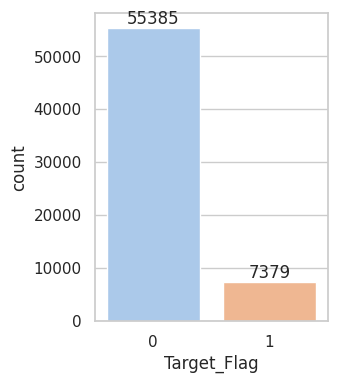

In [19]:
plt.figure(figsize=(3,4))
ax = sns.countplot(x='Target_Flag',data=training_data_out,palette="pastel")
for i in ax.containers:
    ax.bar_label(i,)

## Final Reasoning
Nearly 25% of the default cases is getting wiped out and that is arising from the cases where Max_Loan_Balance_Others, Max_Perc_Def_Chg_Pending, N_PosBkt_L3m where the outliers matter for more defaults.

# Feature Scaling
Used the RobustScaler from scikit-learn to scale the features as our data contains outliers, it is less influenced by extreme values

In [20]:
from sklearn.preprocessing import RobustScaler

# Separate the target variable and features
X = training_data.drop(columns=['Target_Flag'])
y = training_data['Target_Flag']

# Initialize the scaler (use RobustScaler instead of StandardScaler)
scaler = RobustScaler()

# Fit the scaler to the data and transform the features
X_scaled = scaler.fit_transform(X)

# Convert the scaled data back to a DataFrame for better readability
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)

# Problem with SMOTE and balancing dataset

When I balanced the training data using techniques like SMOTE and undersampling of majority data and subsequently trained the model on it, the model learned from a balanced representation of the data. 
1. By oversampling the minority class using SMOTE, there's a risk of overfitting.
2. Balancing the dataset can shift the decision boundary of the classifier. While this might be beneficial in recognizing the minority class in the training set, it might lead to more false positives in real-world data where the majority class is prevalent

Imagine that people that are non-risky gets classified that profile has a higher risk will be a huge disadvantage for the financial institution. The number of customer complaints and customer disatisfaction will increase.

In [21]:
# from imblearn.over_sampling import SMOTE
# from imblearn.under_sampling import RandomUnderSampler
# from imblearn.pipeline import Pipeline

# # Define the resampling strategy
# resampling = Pipeline([
#     ('smote', SMOTE(sampling_strategy=0.3)),
#     ('random_under', RandomUnderSampler(sampling_strategy=1))
# ])

# # Apply the resampling
# X_resampled, y_resampled = resampling.fit_resample(X_scaled_df, y)

# # Verify the new distribution of the target variable
# y_resampled.value_counts()

# Stratified splitting
Stratified splitting means that when you generate a training / validation dataset split, it will attempt to keep the same percentages of classes in each split.

These dataset divisions are usually generated randomly according to a target variable. However, when doing so, the proportions of the target variable among the different splits can differ, especially in the case of small datasets.

In [22]:
from sklearn.model_selection import train_test_split
# Split the resampled data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_scaled_df, y, stratify=y, test_size=0.2, random_state=42)

# Model details
## Base Model: XGBoost:
1. XGBoost focuses on boosting, where emphasis is on reducing bias and variance.
2. XGBoost has an added advantage of regularization which prevents overfitting.
3. XGBoost builds trees sequentially, where each tree corrects the errors of the previous one.


### 1. Hyperparameter Tuning 
Did a randomized search for hyperparameter tuning. Random search is generally more efficient than grid search and can lead to better results in less time. Obtained the best parameters and used further in Bagging Classifier.
### 2. scale_pos_weight=ratio
This parameter is used to address class imbalance. In this case, it is set to ratio, it's intended to handle the imbalance between the default and non-default (positive and negative) classes.
### 3. objective=binary:logistic
It indicates that the model is being trained for binary classification using logistic regression as the base learner. Logistic regression is a common choice for binary classification tasks, including credit risk assessment.
### 4. eval_metric="auc"
It is the intended one for such classification taks.ROC is a probability curve and AUC represents the degree or measure of separability. It tells how much the model is capable of distinguishing between classes.

In [23]:
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score

# # Define the parameter grid
# param_dist = {
#     'learning_rate': [0.01, 0.05, 0.1, 0.5, 1],
#     'n_estimators': [50, 100, 150, 200],
#     'max_depth': [3, 5, 7, 10],
#     'subsample': [0.8, 0.9, 1],
#     'colsample_bytree': [0.8, 0.9, 1],
#     'gamma': [0, 0.1, 0.2, 0.3, 0.4],
#     'alpha': [0, 0.1, 0.2, 0.3, 0.4],
#     'lambda': [0.5, 1, 1.5, 2]
# }
#Best Parameters: {'subsample': 0.8, 'n_estimators': 200, 'max_depth': 5, 'learning_rate': 0.01, 'lambda': 0.5, 'gamma': 0.3, 'colsample_bytree': 1, 'alpha': 0.4}
ratio = float(np.sum(y_train == 0)) / np.sum(y_train == 1)
xgb_model = XGBClassifier(
    scale_pos_weight=ratio,
    objective="binary:logistic",
    random_state=42,
    eval_metric="auc",
    max_depth= 10, 
    learning_rate= 0.05,
    gamma= 0.3,
    alpha= 0.3
)

# # Initialize RandomizedSearchCV
# random_search = RandomizedSearchCV(xgb_model, param_distributions=param_dist, n_iter=100, scoring='roc_auc', cv=5, verbose=3, random_state=42)
# # Fit the model
# random_search.fit(X_train, y_train)

# # Get the best parameters and score
# best_params = random_search.best_params_
# best_score = random_search.best_score_

# print(f"Best Parameters: {best_params}")
# print(f"Best AUC Score: {best_score}")


# Why Bagging on top of XGBoost
1. Bagging (Bootstrap Aggregating) is an ensemble method that involves taking multiple subsets (with replacement) from your training dataset and training a model for each subset. Predictions are made by averaging the predictions from all models. 
2. To make it less sensitive to variations in the training data. This can help the model generalize better to unseen data.
3. Bagging helps reduce the variance of the model, while XGBoost is particularly effective at reducing bias. 

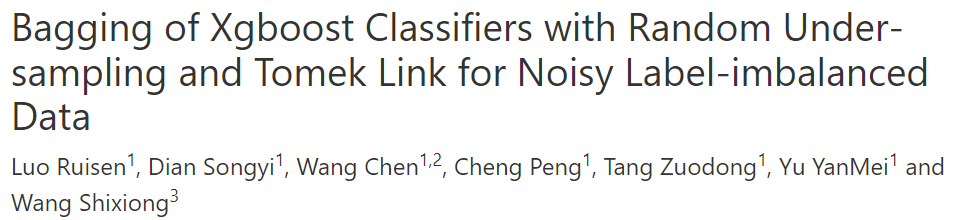[](https://iopscience.iop.org/article/10.1088/1757-899X/428/1/012004)
This [research paper](http://https://iopscience.iop.org/article/10.1088/1757-899X/428/1/012004) has also been used as a basis for this problem statement.

In [24]:
from sklearn.ensemble import BaggingClassifier

bagging_clf = BaggingClassifier(estimator=xgb_model, n_estimators= 200, random_state=42)
bagging_clf.fit(X_train, y_train)

BaggingClassifier(estimator=XGBClassifier(alpha=0.3, base_score=None,
                                          booster=None, callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric='auc', feature_types=None,
                                          gamma=0.3, gpu_id=None,
                                          grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=0.05, max_bin=None,
                                          max_cat_threshold=None,
                                          max_cat_to_onehot=None,
                                          max_delta_step=None, max_depth=10,
                                          max_leaves=None,
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=None,
                                          n_estimators=100, n_jobs=None,
                                          num_parallel_tree=None,
                                          predictor=None, ...),
                  n_estimators=200, random_state=42)

In [25]:
calibrated_probs = bagging_clf.predict_proba(X_val)[:, 1]
results_df = X_val.copy()
results_df['Predicted_Probability'] = calibrated_probs

In [26]:
from sklearn.metrics import roc_auc_score, brier_score_loss, average_precision_score

# Calculate Brier Score
brier = brier_score_loss(y_val, calibrated_probs)
print(f"Brier Score: {brier:.4f}")

auc = roc_auc_score(y_val, calibrated_probs)
print(f"AUC: {auc:.4f}")

Brier Score: 0.1695
AUC: 0.6712


# Applying the same transformations and pre-processing on Validation data

In [27]:
# 1. Handling Negative Family Members based on Age
testing_data.loc[(testing_data['N_Family_Member'] < 0) & (testing_data['Age'] < 25), 'N_Family_Member'] = 0
testing_data.loc[(testing_data['N_Family_Member'] < 0) & (testing_data['Age'] >= 25) & (testing_data['Age'] < 30), 'N_Family_Member'] = 4
testing_data.loc[(testing_data['N_Family_Member'] < 0) & (testing_data['Age'] >= 30) & (testing_data['Age'] < 65), 'N_Family_Member'] = 3

# 2. Impute based on inverse relationship between "Perc_Paymode_Online" and "Perc_Repay_Fail"
indices_3 = testing_data[testing_data['Perc_Paymode_Online'].isna()].index
indices_4 = testing_data[testing_data['Perc_Repay_Fail'].isna()].index
testing_data.loc[indices_3, 'Perc_Paymode_Online'] = 1 - testing_data.loc[indices_3, 'Perc_Repay_Fail']
testing_data.loc[indices_4, 'Perc_Repay_Fail'] = 1 - testing_data.loc[indices_4, 'Perc_Paymode_Online']

# 3. Convert Categorical to Numerical
testing_data['Ever_Default_L12M'] = testing_data['Ever_Default_L12M'].map({"Yes": 1, "No": 0})

# Initialize KNN imputer
knn_imputer = KNNImputer(n_neighbors=7)
# Apply KNN imputation for the selected columns
testing_data[cols_to_impute] = knn_imputer.fit_transform(testing_data[cols_to_impute])

testing_data['Perc_Paymode_Cheq_Fail'] = testing_data['Perc_Paymode_Cheq_Fail'].apply(lambda x: x / 100 if x > 1 else x)
testing_data['Max_Perc_Def_Chg_Pending'] = testing_data['Max_Perc_Def_Chg_Pending'].apply(lambda x: x * 100 if x < 1 else x)
testing_data['N_WorkEx_Yr'] = testing_data['N_WorkEx_Yr'].apply(lambda x: abs(x))
for col in testing_data.select_dtypes(include=['float64', 'int64']).columns:
    testing_data[col].fillna(0, inplace=True)


# Separate the target variable and features
X_test = testing_data.drop(columns=['CoAp_Income', 'Max_Ratio_OC_Pending_POS', 'Total_Field_Trails', 'Customer_No', 'Branch_Code', 'Birth_Year', 'Total_Resolved'])
for i in range(len(poly_features)):
    feature_1 = poly_features[i]
    X_test[feature_1] = X_test[feature_1] * X_test[feature_1]

# Initialize the scaler
scaler = RobustScaler()

# Fit the scaler to the data and transform the features
X_test_scaled = scaler.fit_transform(X_test)
# Convert the scaled data back to a DataFrame for better readability
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test.columns)

In [28]:
# Predict probabilities using the trained XGBoost model
predicted_probs_original = bagging_clf.predict_proba(X_test_scaled_df)[:, 1]

# Create a DataFrame with the original data and the predicted probabilities
results_original_df = X_test_scaled_df.copy()
results_original_df['Probability_Prediction'] = predicted_probs_original

In [29]:
results_original_df['Prediction'] = (results_original_df['Probability_Prediction']>=0.5).astype(int)

In [30]:
submission_df = pd.DataFrame({
    'Customer_No': testing_data['Customer_No'],
    'Prediction': results_original_df['Prediction'],
    'Probability_Prediction': results_original_df['Probability_Prediction']
})
print(submission_df.head())

   Customer_No  Prediction  Probability_Prediction
0        90000           0                0.295411
1        90001           0                0.406947
2        90002           0                0.356359
3        90003           0                0.338921
4        90004           1                0.709596


In [31]:
submission_df.to_csv('/kaggle/working/chandrachud_pati_nitrourkela.csv', index=False)

# Thank You
# Chandrachud Pati, NIT Rourkela